<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/arhuaco/COMP_NC.csv')
trans_df.rename(columns={"arh": "arhuaco"}, inplace = True)
print(trans_df.shape)
print(trans_df.columns)

(5624, 2)
Index(['esp', 'arhuaco'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,arhuaco
622,"la mayor tuvo un hijo, al que llamo moab es e...",ey anawi umun a'zunase'ri gumusinu anukugosa u...
5265,"y les dijeron galileos, que hacen ahi plant...","uyase'ri galilew jina, yari eykigwi ku'na..."
1670,"asi pues, esten tambien ustedes preparados, po...",uweri ema zun migunkwamu kawaki uraku zu paw ...
5042,"ellos alabaron a dios al oir esto, pero al mis...",ey awi ikunha'se' yow winino'kwa uye'ri niwipa...
483,y puso en las manos de su hijo jacob el guiso ...,zamu kujo'na awiri pan nenun dukownari jakobus...


In [7]:
df_dev.head()

,esp,arhuaco
3535,precedera al senor con el espiritu y el poder ...,ey uye' nungwa sakariase'ri uwe'ki azi nu...
589,"aun no se habian acostado, cuando los habitant...","unkumun rizoriwa unwina'zanun nuse'ri, powru s..."
3049,"llegaron a la otra orilla del lago, a la regio...",mt. luk.
181,entonces abimelec mando llamar a isaac y le di...,ey uye' nungwa abimelese'ri kukanun gwa'sa awi...
4573,"en este momento se levanto el rey, junto con e...",eyma winunkuwasayun ingu aykunu keywu rizoyana...


In [8]:
df_test.head()

,esp,arhuaco
3193,cuando los discipulos de juan se enteraron de ...,chokwuse' a'si una'najuri gaysinuse' a'we una....
3928,"pero aun asi, no se alegren tanto de que los e...",ey uwasindi jesuri anugwe dunase' zeyzey a'kus...
318,y anadio no me has dado descendencia y mi he...,ey uye'ri niwipawse'ri mazey gumusinu kink...
3919,"les digo que, en el dia del juicio, los habita...",ey awi katigu a'chanungwa jwin ichunnige'ri em...
5558,"en cuanto a nosotros, sabemos que todos los qu...","uweri niwipaw zun, kaku nana a'zari niwigunkwu..."


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['arhuaco_toks'] = smpl.arhuaco.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['arhuaco_words'] = smpl.arhuaco.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'arhuaco', 'arhuaco_words', 'arhuaco_toks']]

,esp,esp_words,esp_toks,arhuaco,arhuaco_words,arhuaco_toks
5435,dijeron a aaron haznos dioses que nos guien e...,"[dijeron, a, aaron, haznos, dioses, que, nos, ...","[▁di, jeron, ▁a, ▁a, aron, ▁haz, nos, ▁di, ose...",awi aaron keywu winukey ie'ri 'ema moise eg...,"[awi, aaron, keywu, winukey, ie, ', ri, ', ema...","[▁awi, ▁a, aron, ▁key, wu, ▁win, uke, y, ▁ie, ..."
435,"con los primeros rayos del sol, dejaron partir...","[con, los, primeros, rayos, del, sol, ,, dejar...","[▁con, ▁los, ▁primeros, ▁ray, os, ▁del, ▁sol, ...","asige' bunsi unchari, josesin winunkuya jinari...","[asige, ', bunsi, unchari, ,, josesin, winunku...","[▁asi, ge, ', ▁bun, si, ▁un, ch, ari, ,, ▁jos,..."
2635,de quien recibio juan el encargo de bautizar ...,"[de, quien, recibio, juan, el, encargo, de, ba...","[▁de, ▁quien, ▁reci, bio, ▁ju, an, ▁el, ▁encar...",juandi inuse' kun a'wena nari jwasuyari nare...,"[juandi, inuse, ', kun, a, ', wena, nari, jwas...","[▁ju, andi, ▁in, use, ', ▁kun, ▁a, ', wena, ▁n..."
4964,por aquellas fechas se origino un serio motin ...,"[por, aquellas, fechas, se, origino, un, serio...","[▁por, ▁aquel, las, ▁fe, chas, ▁se, ▁orig, ino...",ey ukwe'ri efesori ingunu abiti chuka ikuri o ...,"[ey, ukwe, ', ri, efesori, ingunu, abiti, chuk...","[▁ey, ▁ukwe, ', ri, ▁ef, es, ori, ▁ing, unu, ▁..."
5206,el comandante llego junto a pablo y le pregunt...,"[el, comandante, llego, junto, a, pablo, y, le...","[▁el, ▁comandante, ▁lle, go, ▁junto, ▁a, ▁pab,...",uye' nungwari soldadu zu sakuku umun a'zunari ...,"[uye, ', nungwari, soldadu, zu, sakuku, umun, ...","[▁uye, ', ▁nung, wari, ▁sold, adu, ▁zu, ▁sak, ..."


In [14]:
stats = smpl[['esp_toks', 'arhuaco_toks', 'esp_words', 'arhuaco_words']].applymap(len).describe()
stats

,esp_toks,arhuaco_toks,esp_words,arhuaco_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,31.793500,53.509000,24.975300,33.404700
std,16.778039,28.239867,13.186724,18.404456
min,2.000000,0.000000,2.000000,0.000000
25%,23.000000,37.000000,18.000000,23.000000
50%,30.000000,51.000000,24.000000,32.000000
75%,38.000000,66.000000,30.000000,41.000000
max,420.000000,668.000000,312.000000,450.000000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.arhuaco_toks['mean'] / stats.arhuaco_words['mean'])

1.2729977217490882
1.6018404595760478


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for Wayuu? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.arhuaco) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/5624 [00:00<?, ?it/s]

0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'arhuaco_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'arhuaco_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'arhuaco_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('arhuaco_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('arhuaco', 'arhuaco_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['el siguiente dijo    no puedo ir, porque acabo de casarme  .'], ["gunamuri eygwi unnasiri, ikuri eymi gunti riyuwin zun upawri key ie'ri, upawri o keywu a'zanisiri   ey gun awundi iwari munu' pinzunay powruse' a'mi'riri  nasi, manku, koju, wa'ku neyka jina winzun rinakungwasi winukukanawa  key ie'ri."], 'spa_Latn', 'arhuaco_Cyrl')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_arhuaco_COMP_NC-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 8.0711030960083
1000 4.22352013707161
2000 2.9783524156808854
3000 2.5253718012571333
4000 2.2147490956783296
5000 1.9279473450779916
6000 1.6815865069031715
7000 1.4520561416745186
8000 1.2481238034069537
9000 1.0789354000389575
10000 0.9286817615181208
11000 0.7659086933284998
12000 0.6341515775024891
13000 0.5482586977034807
14000 0.4472939489632845
15000 0.38657390286028387
16000 0.31807284939289093
17000 0.2707877362258732
18000 0.22307867166027426
19000 0.1993416170924902
20000 0.1704841291345656
21000 0.14745519180223346
22000 0.13386371657066048
23000 0.11983874619752169
24000 0.11135870360583067
25000 0.10111765548214316
26000 0.09333654230087995
27000 0.08428039580956101
28000 0.08036115664383396
29000 0.07214123246539385
30000 0.0714602617053315
31000 0.06812993498332799
32000 0.06368349349685014
33000 0.060061354243196544
34000 0.057604629795998334
35000 0.054875522483605894
36000 0.05020794270606711
37000 0.049429135780315846
38000 0.04926727284258232
39000 0.04881998678

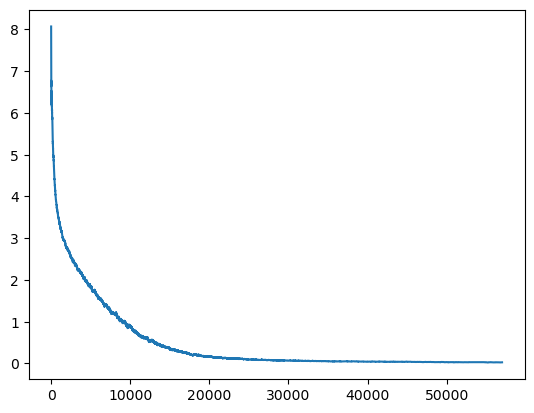

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["ey anawi pabluri nari bernawerisindi eyma'ba kingwi jesu ta wina'chwuyasin birinkuchu unwinachusa una."]
['pablo y bernabe pasaron alli una buena temporada con los demas discipulos.']
['asi que pablo y bernabe se separo de ellos y paso algun tiempo con los discipulos.']


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x  2 jovyan users 4.0K Nov 26 13:07 .
4.0K drwxr-xr-x 10 jovyan users 4.0K Nov 26 13:06 ..
4.0K -rw-r--r--  1 jovyan users  896 Nov 26 16:24 config.json
4.0K -rw-r--r--  1 jovyan users  184 Nov 26 16:24 generation_config.json
2.3G -rw-r--r--  1 jovyan users 2.3G Nov 26 16:24 pytorch_model.bin
4.7M -rw-r--r--  1 jovyan users 4.7M Nov 26 16:24 sentencepiece.bpe.model
4.0K -rw-r--r--  1 jovyan users 3.5K Nov 26 16:24 special_tokens_map.json
4.0K -rw-r--r--  1 jovyan users  570 Nov 26 16:24 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_arhuaco_COMP_NC-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'arhuaco_Cyrl'))

["azi chuwi me'zunniko iwari yow zamu anita'si nungwari"]


In [43]:
translate(t, 'spa_Latn', 'arhuaco_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["awi eygwi unnuwisakuku mika'chonow mikeywin, iwa mikeywikumanige'ri zoya awuri du inu unikwe'ri na'no"]

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='arhuaco_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'arhuaco_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.arhuaco)]
df_test['arhuaco_translated'] = [translate(t, 'spa_Latn', 'arhuaco_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))
print(chrf_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))

BLEU = 7.98 31.1/8.7/4.9/3.4 (BP = 0.972 ratio = 0.972 hyp_len = 24545 ref_len = 25251)
chrF2++ = 25.22
BLEU = 6.66 26.3/8.3/4.1/2.4 (BP = 0.980 ratio = 0.980 hyp_len = 23188 ref_len = 23666)
chrF2++ = 31.43


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['arhuaco', 'esp', 'arhuaco_translated', 'esp_translated']]

,arhuaco,esp,arhuaco_translated,esp_translated
4793,"uweri ema jinari, niwisakuku jesukristu chuka winukizun awkwey windinhure'gowki gun nukundi.",quienes se han dedicado por entero a la causa de nuestro senor jesucristo.,ikunha'ri niwisakuku jesukristu chuka winuka'nugasin winkwuya jinari winukuwitesun rinari nanu'k...,"ya que se han puesto en contacto con ellos para saber que jesucristo, el senor, habia resucitado."
1485,"nundi ujwun zanu nari ne miwisin kwun nu'kwunki, nun a'mia ka' unkisukin kindi ka' nukungeyko...","aunque soy un forastero, un extranjero entre ustedes, vendanme una sepultura en propiedad dent...","ey unige'ri, beku zanu nenun ka'gumuse' gun nunzanundi, iwari miwi ayeygwi ka'gumuse' ka' anikum...",pero jesus les dijo no tengan miedo. ya ven que los que estan aqui no moriran sin antes haber vi...
2638,ey awi jesuse' eygwi winukuya'bari ema ga'kunamu azi a'chwi warunhukwey kao i'munu keywu i...,"que les parece una vez, un hombre que tenia dos hijos le dijo a uno de ellos hijo, hoy ti...","ey uweri i'munu keywu nungwa, i'ngwi cheyrwa mowga gumusinu kununna neyka keywu i'ngwiri nugumus...","el menor dijo padre, ten compasion de mi hijo. le dan ataques que le hacen sufrir lo indecible y..."
5105,"awi inguri birinkuchu ujwun powru zunay nayun nu'narwa kinki, eygwi nu powruse' unnasi wina'zana...","mantengo la esperanza, que comparten tambien mis oponentes, de que dios hara resucitar tanto a l...","niwipawri awanu'ne awgeyka awiri awanu'ne awgeyka du a'zani'nige'ri, niwipawse'ri awanu' nanuya ...",por esta razon me esfuerzo en guardar siempre limpia mi conciencia ante dios y ante los hombres.
996,"uweri ajumeka nukaku zu sinamu siku wu zoriri, nunzey tana nuna'ba a'mia a'guka awiri nugumusinu...",sino que iras a la casa de mi padre y escogeras a una que sea de mi clan .,"uye'ki ikunha'ri jesuse' keywu winukey ie'ri yari nukaku keynaku wu zoriri, i'ngwi nanukin rinun...",pero anoche iras a la casa de tu padre y alli buscaras esposa para mi hijo.
5456,"uye' nungwari pabluri sanedrin jina winiwa'siri cheyrwa sinamu jina, nundi iwakukin niwipaws...","con la mirada fija en los miembros del consejo, dijo pablo hermanos hasta el presente me he c...",ey awi pabluri sanedrin zuneku winkinkumaye'ri'sinamu jina du nanu' neyka niwipawse'ri chowchu n...,"cuando se hizo comparecer pablo ante el consejo, dijo companeros, estoy siendo juzgado digno de ..."
3429,uwe'ki niwipawse' inu agunkwuya kinkiri anunchori uwa'ba zundi ta nunay ni izariza gun nundi zun...,pero la sabiduria se acredita en los que verdaderamente la poseen.simon el fariseo,"simon awiri farisew jina eyki wina'rizasisun rinunna, ey awi wina'rizasisun rinunna.","pero quien pueda entender esto, que lo entienda."
1934,"awi asewa mir moneda jwi ipunnase'ri, nikamu ana'wesi gunti eygwi asukin kawu kure'sana.",el que habia recibido cinco talentos negocio con su capital y lo duplico.,"eyma jwi ipunnase'ri asewa mir moneda jwi ipunnasin, eygwi mowga mir nuna'ba jwi ipunnasin.","los que habia recibido los cinco talentos le echaron luego los cinco talentos mas, y el los dupl..."
2829,"ey uye'ki i'ngwi kwi'mase' zun muku imunusi tukeku a'wasi gwi zwein nu'nari tokuma gwi uye'ri,","pero el, desprendiendose de la sabana, huyo desnudo.jesus ante el consejo supremo",uye'ri jesuse'ri kun keywu zariri muku anukunuku' nari unwa'ka una.,"estaba hablando jesus, cuando llegaron unos de casa del jefe de la sinagoga a decirle a este tu ..."
411,"nukakuri eyki wichu'gwi nare'ri 'unwicha unikwe'ri kanaan a kingwi ka'poti ungowna'ba, ka' is...","mi padre, antes de morir, me hizo jurarle que lo sepultaria en la tumba que el mismo preparo en ...","nukakuse'ri, unwicha anuwe'ri, nukaku isaari eyki ka'gumarigun unnunno na'zari keywu kanaan ka'g...","cuando el joven oyo esto, se quedo extranado de que juan no lo habia encontrado."
